In [1]:
import tensorflow as tf
import numpy as np
import gpflow

from robust_gp import DSM_GPR
from diffusion_matrix import Shrinkage_Diffusion_matrix

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

2023-06-19 12:47:39.240283: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 12:47:39.249923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 12:47:39.345963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-19 12:47:39.347251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 12:47:41.938391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

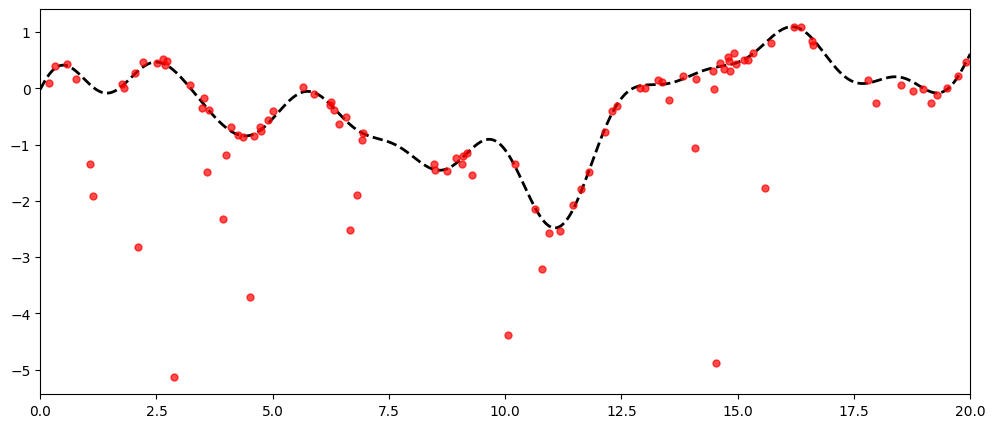

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.1
percent_miss = 0.2

kernel=gpflow.kernels.SquaredExponential()

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

i_mis = np.random.choice(
    np.arange(0, n_obs, 1), int(percent_miss * n_obs), replace=False)

y_obs[i_mis] = y_obs[i_mis] - np.abs(np.random.normal(scale=2, size=len(i_mis))).reshape(len(i_mis),1)

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

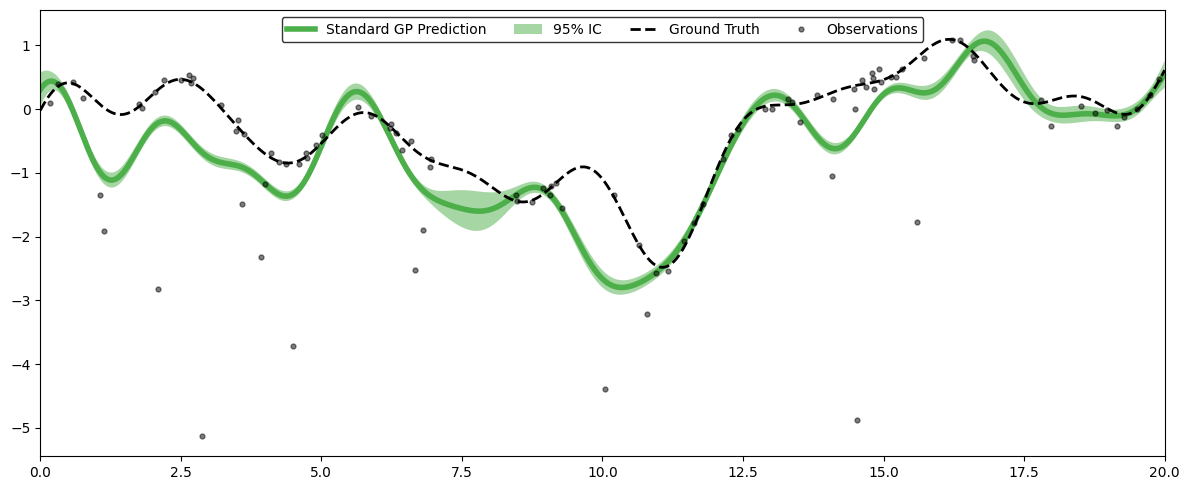

In [4]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

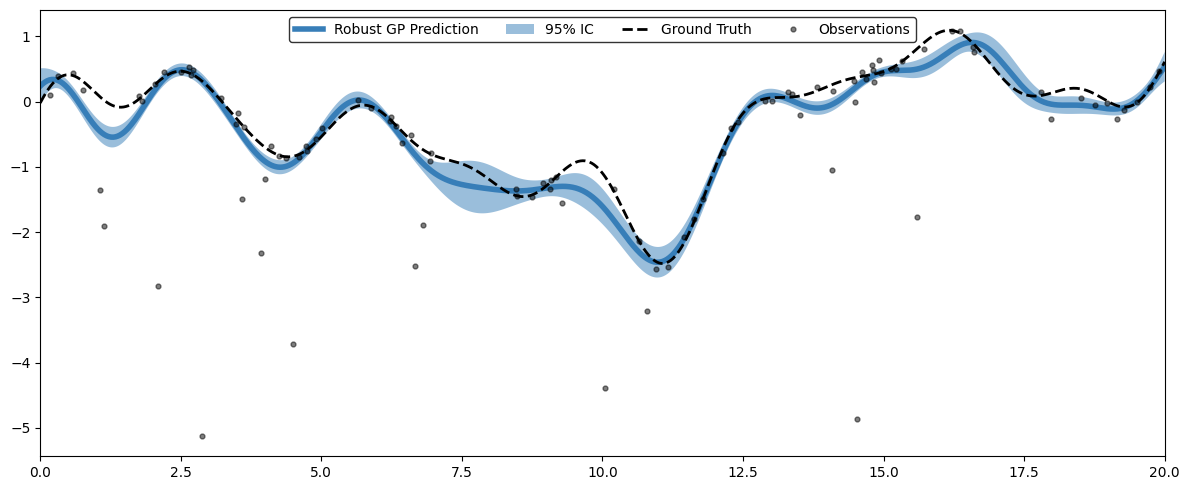

In [5]:
# plot estimation, obs and real data
dsm_gp = DSM_GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(),
    diffusion_matrix = Shrinkage_Diffusion_matrix(),
    noise_variance=sigma_n**2 
)

f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

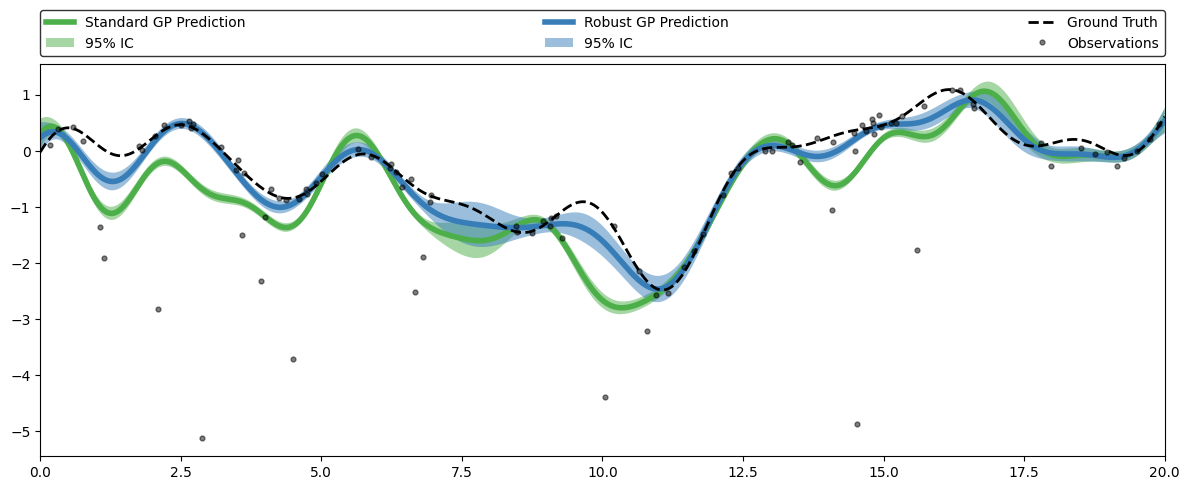

In [6]:
plt.plot(x[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, edgecolor='k')
plt.tight_layout()

In [7]:
print(dsm_gp.log_marginal_likelihood())
print(standard_gp.log_marginal_likelihood())

tf.Tensor(
[[-3.76673930e+02]
 [ 6.80032830e+01]
 [ 1.43403640e+02]
 [ 1.31764806e+02]
 [ 4.14401645e-02]
 [-3.61713454e+03]
 [ 1.29267602e+00]
 [-2.52433104e+03]
 [-4.55112784e+01]
 [-1.04218374e+01]
 [ 5.63242900e+01]
 [ 3.98342665e+01]
 [-7.55199477e+01]
 [-1.39761001e+04]
 [-1.18933202e+03]
 [-3.16897709e+02]
 [-1.01295874e+02]
 [ 2.36047478e+02]
 [ 2.96681881e+01]
 [ 6.33780955e+01]
 [ 2.35865136e+02]
 [ 7.47582042e+01]
 [-4.63853792e-01]
 [ 3.41194308e+01]
 [-3.81086624e+02]
 [ 6.14200631e+01]
 [ 1.66199536e+01]
 [-1.49027591e+02]
 [ 1.12509301e+01]
 [-8.84276027e+02]
 [-1.09560297e+03]
 [-1.00973938e+02]
 [-4.77408130e+02]
 [ 6.64097739e-01]
 [ 4.77898149e+01]
 [ 2.35080055e+01]
 [ 5.59393625e+01]
 [-9.13424514e+01]
 [-2.22808588e+02]
 [-1.42927061e+02]
 [-1.95304861e+00]
 [-1.28545016e+01]
 [ 1.47737337e+01]
 [-1.28401031e+02]
 [-2.85694769e+01]
 [ 8.34619642e+00]
 [ 6.34740386e+00]
 [-5.49701259e+03]
 [ 5.54111351e+01]
 [-1.67889226e+02]
 [-1.20543359e+04]
 [-1.88317248e+03]
 

Tensor("sub:0", shape=(100, 1), dtype=float64)
Tensor("Sum_1:0", shape=(), dtype=float64)
Tensor("Sum_4:0", shape=(), dtype=float64)
╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ DSM_GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ DSM_GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ DSM_GPR.likelihood.variance │ Parameter │ Soft

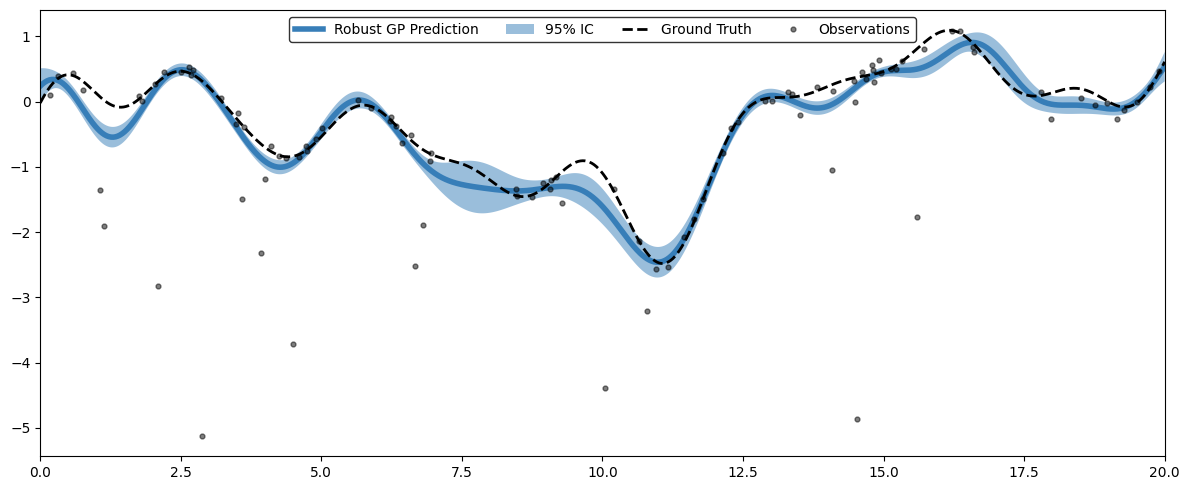

In [8]:
# plot estimation, obs and real data
dsm_gp = DSM_GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(1,1),
    diffusion_matrix = Shrinkage_Diffusion_matrix(),
    noise_variance=sigma_n**2 
)

opt = gpflow.optimizers.Scipy()
opt.minimize(dsm_gp.training_loss, dsm_gp.trainable_variables)

f_mean_dsm, f_var_dsm = dsm_gp.predict_f(x, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)
plt.plot(x[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

gpflow.utilities.print_summary(dsm_gp)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.72785 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.79509 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.10599 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

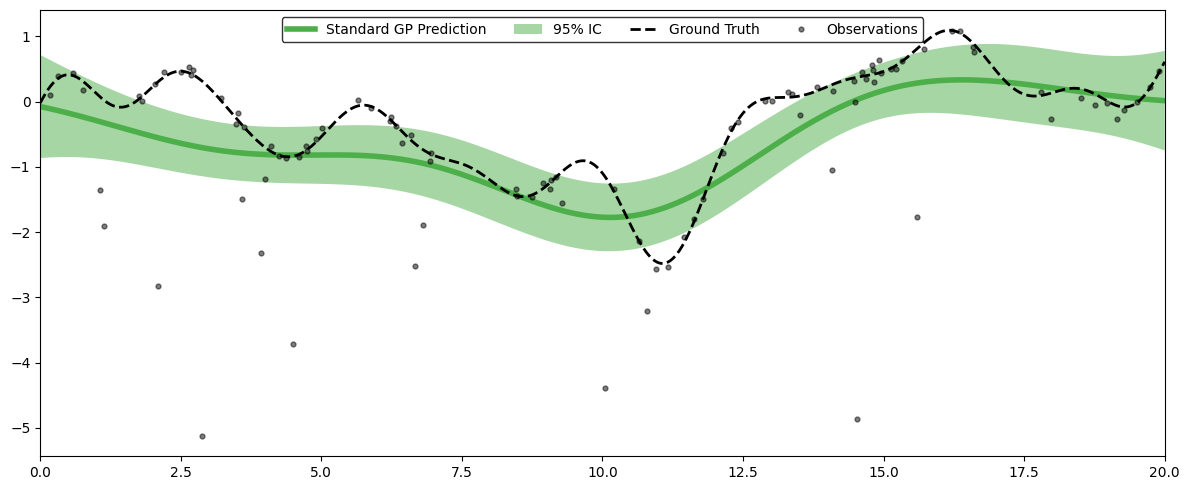

In [8]:
# plot estimation, obs and real data
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(1,1),
    diffusion_matrix = Shrinkage_Diffusion_matrix(),
    noise_variance=sigma_n**2
)

opt = gpflow.optimizers.Scipy()
opt.minimize(standard_gp.training_loss, standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    x[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
plt.plot(x, f, color='black', ls='--', lw=2, label='Ground Truth')
plt.plot(x_obs, y_obs, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(x[0], x[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

gpflow.utilities.print_summary(standard_gp)

In [11]:
likelihoods = np.zeros([50,50])
for i in range(1,50):
    for j in range(1,50):
        dsm_gp = DSM_GPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(j,i),
        diffusion_matrix = Shrinkage_Diffusion_matrix(),
        noise_variance=sigma_n**2 
        )
        likelihoods[i,j] = dsm_gp.log_marginal_likelihood()

plt.imshow(likelihoods)
plt.colorbar()

TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.

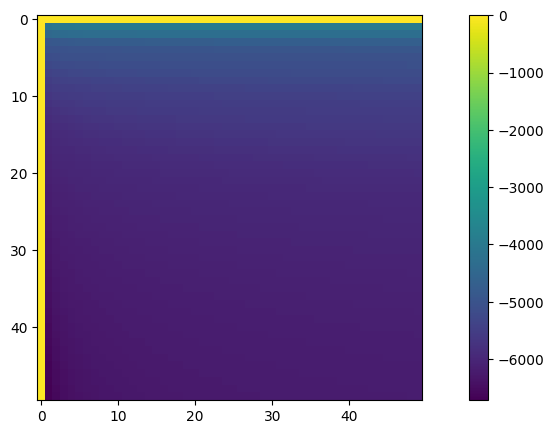

In [12]:
likelihoods = np.zeros([50,50])
for i in range(1,50):
    for j in range(1,50):
        dsm_gp = gpflow.models.GPR(
        (x_obs, y_obs),
        kernel=gpflow.kernels.SquaredExponential(j,i),
        noise_variance=sigma_n**2 
        )
        likelihoods[i,j] = dsm_gp.log_marginal_likelihood()

plt.imshow(likelihoods)
plt.colorbar()

In [16]:
def nu(x, variance=0.01):
    return x*(1+x**2)*(variance**-1) + 2*x*(1+x**2)**-2

def c(x, variance=0.01):
    return (variance**-1) * x**2 /(2*(1+x**2)) + 2*x**2 /(1+x**2)**2 -2/  (1+x**2)

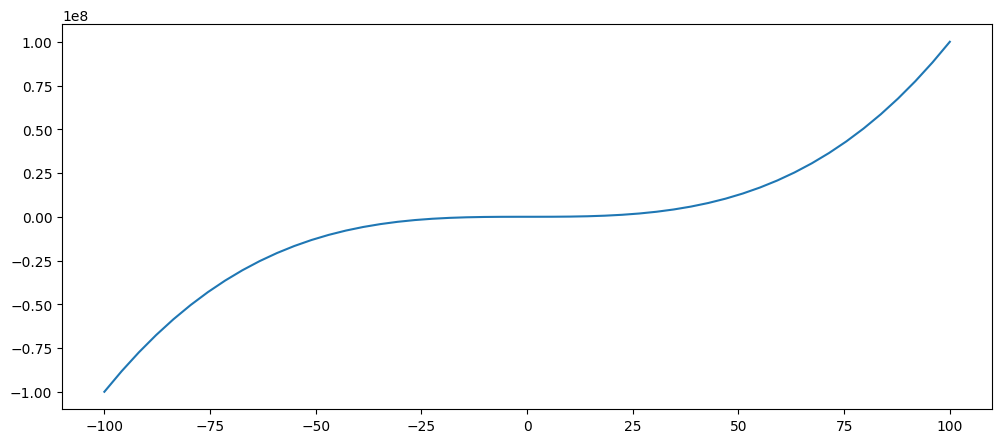

In [18]:
x = np.linspace(-100,100)
plt.plot(x,nu(x))

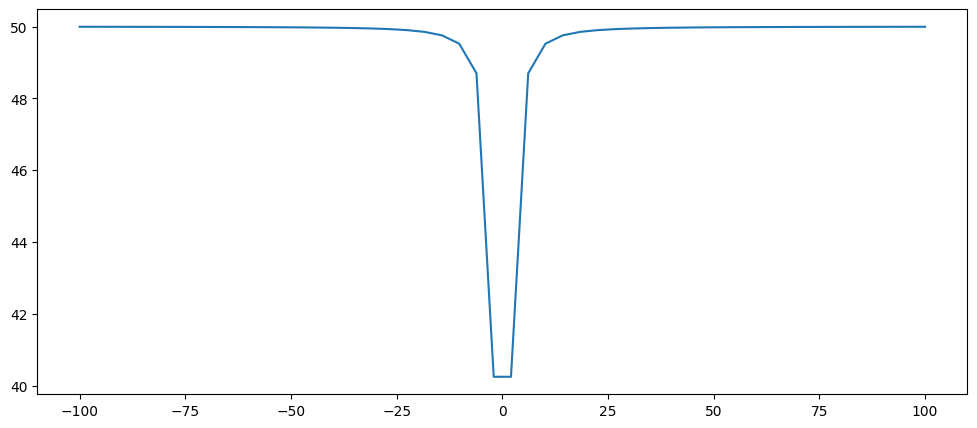

In [19]:
x = np.linspace(-100,100)
plt.plot(x,c(x))